# Example: Emotion Feature Extraction With Mexca

In this notebook, we will use the US presidential debate between Clinton and Trump in 2016 as an example to extract and compare emotion expressions with **mexca**. The video can be found on [YouTube](https://www.youtube.com/watch?v=DBhrSdjePkk), but we will use a file that is hosted by a third party. In contrast to the `demo.ipynb` notebook, we will dive deeper into different options and arguments that **mexca** provides and put more emphasis on analyzing the pipeline output.

In [1]:
import logging
import os
import yaml
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from huggingface_hub import notebook_login
from IPython.display import Video
from urllib.request import urlopen
from mexca.container import AudioTranscriberContainer, FaceExtractorContainer, SentimentExtractorContainer, SpeakerIdentifierContainer, VoiceExtractorContainer
from mexca.pipeline import Pipeline

If not already done, we first need to download the video file:

In [2]:
def download_example(url, filename):
    # Check if filename exists
    if not os.path.exists(filename):
        video = urlopen(url)

        with open(filename, 'wb') as file:
            file.write(video.read())

In [3]:
example_url = 'https://books.psychstat.org/rdata/data/debate.mp4'
filename = 'debate.mp4'

download_example(example_url, filename)

Video(filename)

## Building the Pipeline

Next, we build the pipeline by combining different steps for video, audio, and text processing. To detect and extract features from faces shown in the video, we include a `FaceExtractorContainer` object. This object will call a container of the `FaceExtractor` class which already includes all requirements (dependencies and pretrained models). From a quick inspection of the video, we can guess that mostly two faces will be shown (Clinton's and Trump's), so we set `num_faces=2`. This means that detected faces will be assigned to two clusters based on their encoded representations (embeddings). In the current version of **mexca**, setting this argument is important as too many or too few face clusters might be chosen automatically otherwise.

In [4]:
n_clusters = 2

face_extractor = FaceExtractorContainer(num_faces=n_clusters)

*Note*: mexca builds on pretrained models from the pyannote.audio package. Since release 2.1.1, downloading the pretrained models requires the user to accept two user agreements on Hugging Face hub and generate an authentication token. Therefore, to run the mexca pipeline, please accept the user agreements on [here](https://huggingface.co/pyannote/speaker-diarization) and [here](https://huggingface.co/pyannote/segmentation). Then, generate an authentication token [here](https://huggingface.co/settings/tokens). Use this token to login when running `notebook_login()`. You only need to login when running mexca for the first time.

In [5]:
# Only required the first time to store the token
notebook_login()

For the audio processing, we create two components: The `SpeakerIdentifierContainer` detects speech segmenets in the audio signal and assigns them to speaker clusters. As with the faces, we assume that the video has two speakers, so we set `num_speakers=2`.

In [6]:
speaker_identifier = SpeakerIdentifierContainer(
    num_speakers=n_clusters,
    use_auth_token="HF_TOKEN" # Replace this string with your token
)

The `VoiceExtractorContainer` calculates the voice pitch (fundamental frequency F0) which is an emotion expression feature.

In [7]:
voice_extractor = VoiceExtractorContainer()

To extract the sentiment from the spoken text, we create two text processing components. First, we transcribe the audio signal to text using the `AudioTranscriber` class. The component automatically detects the spoken language of each speech segment. The transcribed text is split into single sentences.

In [8]:
audio_transcriber = AudioTranscriberContainer()

Second, the `SentimentExtractor` predicts a positive, negative, and neutral sentiment score for each sentence.

In [9]:
sentiment_extractor = SentimentExtractorContainer()

Now, we combine the five components into a `Pipeline` instance, which will run them after each other and integrate the results.

In [10]:
pipeline = Pipeline(
    face_extractor=face_extractor,
    speaker_identifier=speaker_identifier,
    voice_extractor=voice_extractor,
    audio_transcriber=audio_transcriber,
    sentiment_extractor=sentiment_extractor
)

To track the progress of the pipeline, we create a logger from the `logging.yml` file in this directory.

In [11]:
with open('logging.yml', 'r', encoding='utf-8') as file:
    config = yaml.safe_load(file)
    logging.config.dictConfig(config)

To run the **mexca** pipeline, we call the apply method, we call the `apply()` method. The video has a frame rate of 25 and to speed up the processing, we choose to process 5 video frames at at time (`frame_batch_size=5`) and to only process every 5th frame (`skip_frames=5`), assuming that emotion expressions don't change substantially faster than 200ms. For this example, we also indicate to only process the first 30 seconds using `process_subclip=(0, 30)`.

**Note**: The first time you run the pipeline with containerzied components, the containers will be automatically downloaded which can take some time.

In [12]:
output = pipeline.apply(
    filename,
    frame_batch_size=5,
    skip_frames=5,
    process_subclip=(0, 30)
)

2023-01-26 14:57:29,858 - INFO - Starting MEXCA pipeline
2023-01-26 14:57:30,355 - INFO - Wrote audio file to debate.wav
2023-01-26 14:57:30,363 - INFO - Processing video frames
100%|██████████| 31/31 [01:32<00:00,  2.98s/it]

2023-01-26 14:59:20,822 - INFO - Identifying speakers
torchvision is not available - cannot save figures

2023-01-26 15:01:04,969 - INFO - Transcribing speech segments to text
100%|██████████| 4/4 [01:03<00:00, 15.86s/it]


Detected language: english
Detected language: english
Detected language: english
Detected language: english

2023-01-26 15:02:15,201 - INFO - Extracting sentiment from transcribed text
100%|██████████| 10/10 [00:20<00:00,  2.05s/it]

2023-01-26 15:02:49,368 - INFO - Extracting voice features
2023-01-26 15:02:53,371 - INFO - Removing audio file at debate.wav
2023-01-26 15:02:53,381 - INFO - MEXCA pipeline finished


To simplify further processing, we store the `features` attribute from the output of the pipeline which contains the integrated features as a `pandas.DataFrame` in a separate variable.

In [13]:
output_df = output.features

## Analyzing Facial Expressions

We start analyzing the output by comparing facial action unit activations between Clinton and Trump.

In [14]:
def stderr(x):
    """Calculate the standard error of the mean
    """
    return np.std(x)/np.sqrt(len(x))

In [15]:
clinton_id = 1
trump_id = 0

In [16]:
# Expand action unit lists into separate columns
au_df = (output_df['face_aus']
    .apply(pd.Series)
    .rename(columns=lambda x: f'au_{x}')
)
au_df['face_label'] = output_df['face_label']

# Compute mean and standard error for each action unit
au_stats = au_df.groupby(['face_label']).agg([np.mean, stderr])

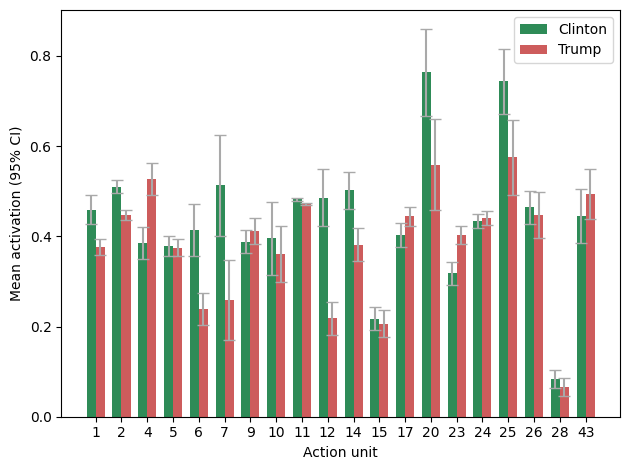

In [17]:
n_au = 20 # Nr of action units
aus = np.arange(n_au)

# Reference id of the action unit
au_ref = [1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 14, 15, 17, 20, 23, 24, 25, 26, 28, 43]

clinton_au_means = np.array([au_stats[f'au_{i}']['mean'][clinton_id] for i in aus])
clinton_au_stderrs = np.array([au_stats[f'au_{i}']['stderr'][clinton_id] for i in aus])

trump_au_means = np.array([au_stats[f'au_{i}']['mean'][trump_id] for i in aus])
trump_au_stderrs = np.array([au_stats[f'au_{i}']['stderr'][trump_id] for i in aus])

# Create bar plot with error bars
width = 0.35

fig, ax = plt.subplots()

ax.bar(aus-width/2, clinton_au_means, width, yerr=1.96*clinton_au_stderrs, capsize=4,
    ecolor='darkgray', label='Clinton', color='seagreen')
ax.bar(aus+width/2, trump_au_means, width, yerr=1.96*trump_au_stderrs, capsize=4,
    ecolor='darkgray', label='Trump', color='indianred')

ax.set_xlabel('Action unit')
ax.set_xticks(aus, au_ref)
ax.set_ylabel('Mean activation (95% CI)')
ax.legend()

fig.tight_layout()

plt.show()


The FaceExtractor compoenent extracts the activations of 20 action units. The bar plot shows substantial differences between Clinton and Trump in the mean activations of units associated with joy (6 and 12). There are also differences in units related to sadness (1 and 4), although they point in opposite directions. Moreover, Clinton shows higher mean activations related to fear (1, 2, 7, and 20; 5 in opposite direction), whereas Trump does for anger-related units (4, 23; 7 in opposite direction). For contempt-related units (12 and 14), Clinton shows higher activations. Note that these results must interpreted with care, as we are not comparing the activations against a reference data base or baseline.

## Analyzing the Voice

Besides facial emotion expressions, **mexca** also allows us to analyze vocal expressions. Currently, it only extracts the voice pitch measured as the fundamental frequency F0 from speakers in the video which indicates emphasis and is related to emotional arousal. Similar to the action units, we can compare voice pitch between Clinton and Trump.

In [18]:
# Extract voice pitch and calculate statistics
clinton_pitch = output_df.pitch_f0[output_df.segment_speaker_label == str(clinton_id)]
clinton_time = output_df.time[output_df.segment_speaker_label == str(clinton_id)]
trump_pitch = output_df.pitch_f0[output_df.segment_speaker_label == str(trump_id)]
trump_time = output_df.time[output_df.segment_speaker_label == str(trump_id)]

clinton_pitch_mean = np.mean(clinton_pitch)
clinton_pitch_stderr = stderr(clinton_pitch)

trump_pitch_mean = np.mean(trump_pitch)
trump_pitch_stderr = stderr(trump_pitch)


In [19]:
output.audio_annotation

IntervalTree([Interval(8.92, 17.439999999999998, SegmentData(filename='debate', channel=1, name='1', conf=None)), Interval(17.44, 27.11, SegmentData(filename='debate', channel=1, name='0', conf=None)), Interval(21.51, 21.970000000000002, SegmentData(filename='debate', channel=1, name='1', conf=None)), Interval(27.11, 29.46, SegmentData(filename='debate', channel=1, name='1', conf=None))])

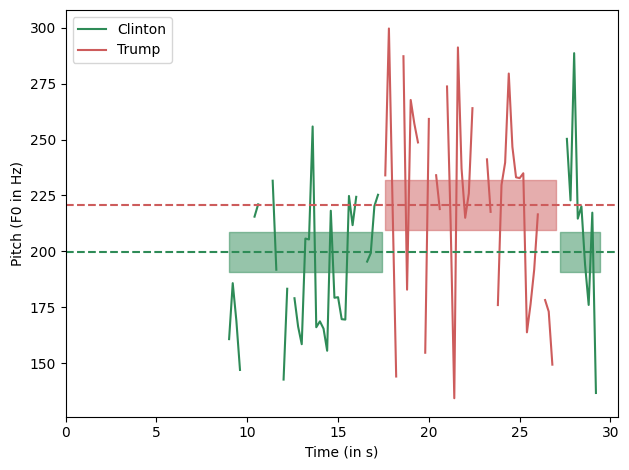

In [20]:
# Create line plot with mean and confidence bands
fig, ax = plt.subplots()

ax.plot(clinton_time[clinton_time < np.min(trump_time)], clinton_pitch[clinton_time < np.min(trump_time)], label='Clinton', color='seagreen')
ax.plot(clinton_time[clinton_time > np.max(trump_time)], clinton_pitch[clinton_time > np.max(trump_time)], color='seagreen')
ax.plot(trump_time, trump_pitch, label='Trump', color='indianred')

ax.axhline(clinton_pitch_mean, ls='--', color='seagreen')
ax.fill_between(
    clinton_time[clinton_time < np.min(trump_time)],
    clinton_pitch_mean+1.96*clinton_pitch_stderr,
    clinton_pitch_mean-1.96*clinton_pitch_stderr,
    color='seagreen',
    alpha=0.5,
)

ax.fill_between(
    clinton_time[clinton_time > np.max(trump_time)],
    clinton_pitch_mean+1.96*clinton_pitch_stderr,
    clinton_pitch_mean-1.96*clinton_pitch_stderr,
    color='seagreen',
    alpha=0.5,
)
ax.axhline(trump_pitch_mean, ls='--', color='indianred')
ax.fill_between(
    trump_time,
    trump_pitch_mean+1.96*trump_pitch_stderr,
    trump_pitch_mean-1.96*trump_pitch_stderr,
    color='indianred',
    alpha=0.5,
)

ax.set_xlabel('Time (in s)')
ax.set_xticks(np.arange(35, step=5.0))
ax.set_ylabel('Pitch (F0 in Hz)')
ax.legend()

fig.tight_layout()

plt.show()


The figure shows the voice pitch of Clinton and Trump over time and displays the mean pitch (dashed line) with confidence bands (95% CI). It shows that the baseline pitch of Trump's voice is higher on average than Clinton's. However, to draw meaningful conclusions about differences in expressed emotions, we would need to compare the pitch in specific parts of speech against the baseline (which goes beyond this example).

## Analyzing the Text

Next to facial expressions and voice features, **mexca** can also extract the sentiment from the spoken text. Again, we can compare the positive, negative, and neutral sentiment in the speech content between Clinton and Trump.

In [21]:
output.transcription.subtitles

IntervalTree([Interval(9.43, 15.56, TranscriptionData(index=1, text=' I was against it once it was finally negotiated and the terms were laid out.', speaker='1')), Interval(15.78, 16.76, TranscriptionData(index=2, text=' I wrote about that in- you called it the-', speaker='1')), Interval(18.04, 18.26, TranscriptionData(index=3, text=' gold standard.', speaker='0')), Interval(18.81, 19.0, TranscriptionData(index=4, text=' Well, I hope I...', speaker='0')), Interval(19.34, 21.34, TranscriptionData(index=5, text=' You called it the gold standard of trade deals.', speaker='0')), Interval(21.67, 21.84, TranscriptionData(index=6, text=' You know what?', speaker='1')), Interval(21.88, 22.27, TranscriptionData(index=7, text=' You know what?', speaker='0')), Interval(22.78, 23.68, TranscriptionData(index=8, text=" He said it's the finest deal you've ever seen.", speaker='0')), Interval(24.51, 26.94, TranscriptionData(index=9, text=' No. And then you heard what I said about it and all of a sudde

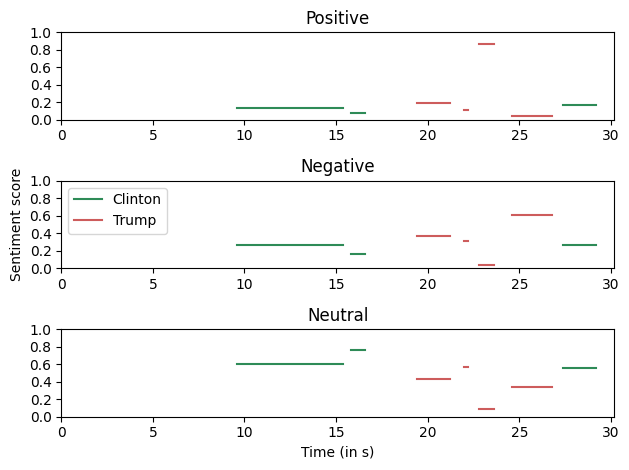

In [22]:
# Extract text sentiment
clinton_sent_pos = output_df.span_sent_pos[output_df.segment_speaker_label == str(clinton_id)]
clinton_sent_neg = output_df.span_sent_neg[output_df.segment_speaker_label == str(clinton_id)]
clinton_sent_neu = output_df.span_sent_neu[output_df.segment_speaker_label == str(clinton_id)]
trump_sent_pos = output_df.span_sent_pos[output_df.segment_speaker_label == str(trump_id)]
trump_sent_neg = output_df.span_sent_neg[output_df.segment_speaker_label == str(trump_id)]
trump_sent_neu = output_df.span_sent_neu[output_df.segment_speaker_label == str(trump_id)]

# Create line plot
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

ax1.plot(clinton_time, clinton_sent_pos, label='Clinton', color='seagreen')
ax1.plot(trump_time, trump_sent_pos, label='Trump', color='indianred')
ax2.plot(clinton_time, clinton_sent_neg, label='Clinton', color='seagreen')
ax2.plot(trump_time, trump_sent_neg, label='Trump', color='indianred')
ax3.plot(clinton_time, clinton_sent_neu, label='Clinton', color='seagreen')
ax3.plot(trump_time, trump_sent_neu, label='Trump', color='indianred')

ax1.set_title('Positive')
ax2.set_title('Negative')
ax3.set_title('Neutral')
ax3.set_xlabel('Time (in s)')
for ax in (ax1, ax2, ax3):
    ax.set_xticks(np.arange(35, step=5.0))
    ax.set_yticks(np.arange(1.2, step=0.2))
ax2.set_ylabel('Sentiment score')
ax2.legend()

fig.tight_layout()

plt.show()

We can see that Clinton uses relatively neutral sentiment. Trump, in contrast, has a strongly positive peak in his turn when he talks about "the finest deal you've ever seen" and a negative peak at "all of a sudden you were against it".


## Summary

In this example, we build a custom pipeline using the **mexca** package to extract emotion expressions from a video. We ran the pipeline on an excerpt from the US presidential debate 2016 between Clinton and Trump. We analyzed differences in facial action unit activations, voice pitch, and speech text sentiment between the two candidates.